# Protocol Selection of FedLeak (Resize Generator), ImageNet(ISLVRC2012)

Here is the protocol selection to decide in which way should FedLeak be transferred.

We evaluate it with ***ImageNet(ISLVRC2012)***, with $5$ times sampling batch = $16$, reporting the best results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from test-set, with `shuffle=False`.
- *Way to report*: best PSNRs in $5$ times recovery.

Codes are aligned with `sanity_check_resize_ImageNet.ipynb`, with two modifications utilized:
- ⭕ Force generating with $224\times224\times3$.
- ⭕ Abort comparing with `upsampling` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, utils, argparse, os
from criteria import *
from utils import upscale, get_resnet18
from resize_generator import FedLeak
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:0")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((224, 224))
])

dataset = torchvision.datasets.ImageNet(root="~/data/imagenet/", split="val", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
loader_iter = iter(trainloader)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

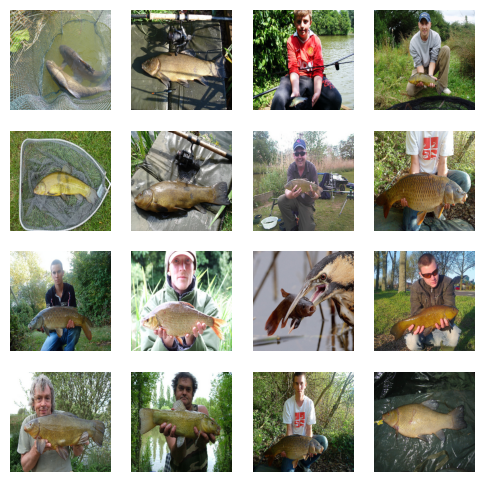

| It: 1 | Loss: -39.7581 | Time:   5.98s |


| It: 1001 | Loss: -58.6945 | Time: 783.53s |


| It: 2001 | Loss: -59.8561 | Time: 786.50s |


| It: 3001 | Loss: -60.4311 | Time: 785.31s |


| It: 4001 | Loss: -60.7501 | Time: 784.76s |


| It: 5001 | Loss: -60.9814 | Time: 785.36s |


| It: 6001 | Loss: -61.1797 | Time: 784.61s |


| It: 7001 | Loss: -61.3079 | Time: 783.44s |


| It: 8001 | Loss: -61.3885 | Time: 785.07s |


| It: 9001 | Loss: -61.4318 | Time: 784.74s |


| It: 1 | Loss: -42.0977 | Time:   0.83s |


| It: 1001 | Loss: -59.0435 | Time: 784.62s |


| It: 2001 | Loss: -60.0097 | Time: 784.19s |


| It: 3001 | Loss: -60.5112 | Time: 783.80s |


| It: 4001 | Loss: -60.8117 | Time: 784.10s |


| It: 5001 | Loss: -61.0454 | Time: 785.38s |


| It: 6001 | Loss: -61.2051 | Time: 785.54s |


| It: 7001 | Loss: -61.3292 | Time: 785.63s |


| It: 8001 | Loss: -61.4007 | Time: 786.22s |


| It: 9001 | Loss: -61.4424 | Time: 785.71s |


| It: 1 | Loss: -42.6494 | Time:   0.84s |


| It: 1001 | Loss: -58.2427 | Time: 786.28s |


| It: 2001 | Loss: -59.7202 | Time: 785.88s |


| It: 3001 | Loss: -60.3114 | Time: 786.80s |


| It: 4001 | Loss: -60.6392 | Time: 785.47s |


| It: 5001 | Loss: -60.9033 | Time: 785.40s |


| It: 6001 | Loss: -61.1065 | Time: 785.70s |


| It: 7001 | Loss: -61.2493 | Time: 784.86s |


| It: 8001 | Loss: -61.3379 | Time: 785.00s |


| It: 9001 | Loss: -61.3809 | Time: 784.51s |


| It: 1 | Loss: -39.6423 | Time:   0.83s |


| It: 1001 | Loss: -59.1357 | Time: 785.96s |


| It: 2001 | Loss: -60.1984 | Time: 786.04s |


| It: 3001 | Loss: -60.7680 | Time: 785.84s |


| It: 4001 | Loss: -60.9577 | Time: 785.02s |


| It: 5001 | Loss: -61.1838 | Time: 786.40s |


| It: 6001 | Loss: -61.3100 | Time: 786.11s |


| It: 7001 | Loss: -61.4107 | Time: 786.81s |


| It: 8001 | Loss: -61.4827 | Time: 786.03s |


| It: 9001 | Loss: -61.5182 | Time: 785.73s |


| It: 1 | Loss: -41.0238 | Time:   0.80s |


| It: 1001 | Loss: -59.3130 | Time: 785.80s |


| It: 2001 | Loss: -60.5640 | Time: 784.56s |


| It: 3001 | Loss: -60.9524 | Time: 785.96s |


| It: 4001 | Loss: -61.1850 | Time: 785.15s |


| It: 5001 | Loss: -61.3407 | Time: 786.04s |


| It: 6001 | Loss: -61.4296 | Time: 786.59s |


| It: 7001 | Loss: -61.5186 | Time: 785.99s |


| It: 8001 | Loss: -61.5773 | Time: 786.08s |


| It: 9001 | Loss: -61.6042 | Time: 786.19s |


BEST PSNR: 9.4559
MEDIAN PSNR: 9.0297
ALL PSNR: [9.0558, 9.0752, 8.7592, 8.8026, 8.8026]


<Figure size 400x300 with 0 Axes>

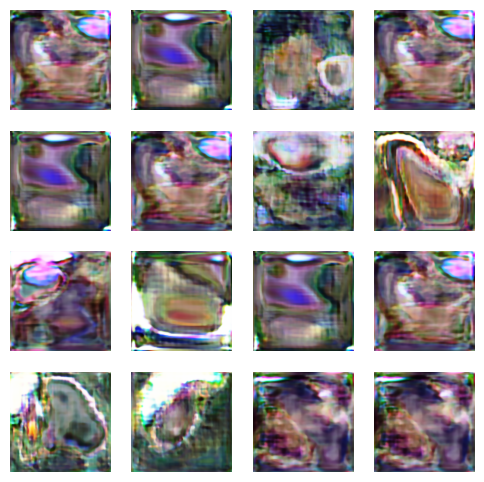

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

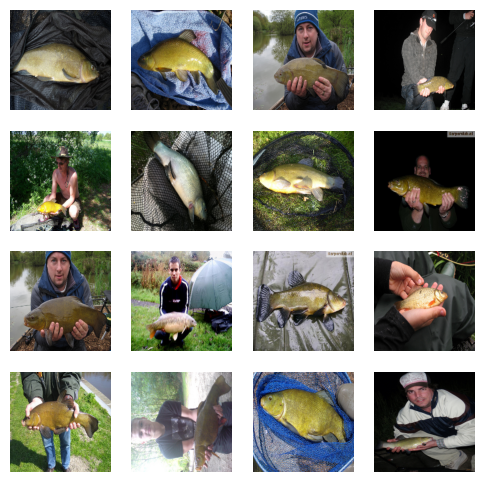

| It: 1 | Loss: -40.4106 | Time:   0.74s |


| It: 1001 | Loss: -59.3299 | Time: 785.50s |


| It: 2001 | Loss: -60.1758 | Time: 785.67s |


| It: 3001 | Loss: -60.7010 | Time: 786.04s |


| It: 4001 | Loss: -61.0172 | Time: 784.85s |


| It: 5001 | Loss: -61.2119 | Time: 785.60s |


| It: 6001 | Loss: -61.3515 | Time: 786.01s |


| It: 7001 | Loss: -61.4416 | Time: 786.42s |


| It: 8001 | Loss: -61.5116 | Time: 786.35s |


| It: 9001 | Loss: -61.5411 | Time: 785.82s |


| It: 1 | Loss: -41.4922 | Time:   0.87s |


| It: 1001 | Loss: -59.8736 | Time: 785.72s |


| It: 2001 | Loss: -60.6528 | Time: 786.03s |


| It: 3001 | Loss: -61.0681 | Time: 785.70s |


| It: 4001 | Loss: -61.2702 | Time: 785.76s |


| It: 5001 | Loss: -61.3978 | Time: 785.33s |


| It: 6001 | Loss: -61.4988 | Time: 786.01s |


| It: 7001 | Loss: -61.5781 | Time: 786.20s |


| It: 8001 | Loss: -61.6222 | Time: 785.82s |


| It: 9001 | Loss: -61.6452 | Time: 785.94s |


| It: 1 | Loss: -40.3925 | Time:   0.84s |


| It: 1001 | Loss: -58.9546 | Time: 786.11s |


| It: 2001 | Loss: -59.7716 | Time: 786.06s |


| It: 3001 | Loss: -60.5054 | Time: 786.28s |


| It: 4001 | Loss: -60.8470 | Time: 786.68s |


| It: 5001 | Loss: -61.1058 | Time: 786.31s |


| It: 6001 | Loss: -61.2791 | Time: 785.81s |


| It: 7001 | Loss: -61.3948 | Time: 786.34s |


| It: 8001 | Loss: -61.4678 | Time: 786.81s |


| It: 9001 | Loss: -61.5032 | Time: 785.15s |


| It: 1 | Loss: -41.9236 | Time:   0.83s |


| It: 1001 | Loss: -59.4537 | Time: 786.54s |


| It: 2001 | Loss: -60.5511 | Time: 785.01s |


| It: 3001 | Loss: -60.9269 | Time: 786.03s |


| It: 4001 | Loss: -61.1749 | Time: 784.89s |


| It: 5001 | Loss: -61.3187 | Time: 785.24s |


| It: 6001 | Loss: -61.4144 | Time: 786.02s |


| It: 7001 | Loss: -61.5101 | Time: 785.26s |


| It: 8001 | Loss: -61.5625 | Time: 785.68s |


| It: 9001 | Loss: -61.5874 | Time: 785.89s |


| It: 1 | Loss: -41.0249 | Time:   0.80s |


| It: 1001 | Loss: -59.8833 | Time: 784.75s |


| It: 2001 | Loss: -60.6242 | Time: 786.22s |


| It: 3001 | Loss: -61.0176 | Time: 785.68s |


| It: 4001 | Loss: -61.2469 | Time: 785.80s |


| It: 5001 | Loss: -61.3938 | Time: 785.91s |


| It: 6001 | Loss: -61.4854 | Time: 785.82s |


| It: 7001 | Loss: -61.5649 | Time: 785.24s |


| It: 8001 | Loss: -61.6149 | Time: 785.54s |


| It: 9001 | Loss: -61.6406 | Time: 786.41s |


BEST PSNR: 8.7002
MEDIAN PSNR: 8.0520
ALL PSNR: [8.0823, 8.7002, 8.2432, 7.6196, 7.6196]


<Figure size 400x300 with 0 Axes>

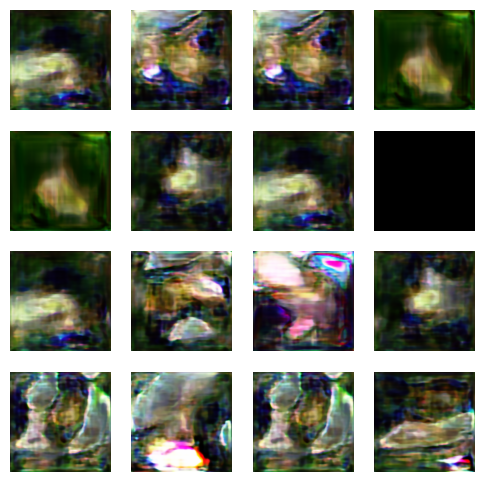

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

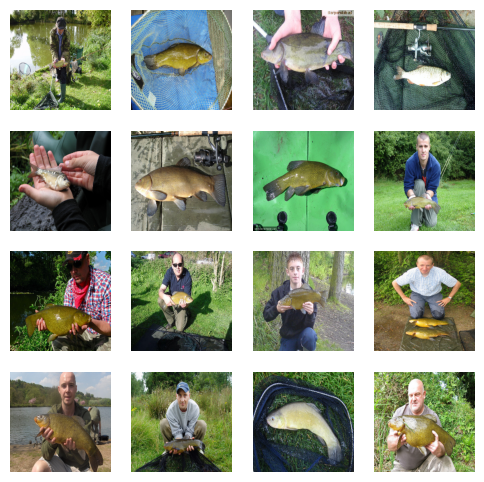

| It: 1 | Loss: -38.9318 | Time:   0.75s |


| It: 1001 | Loss: -59.1516 | Time: 785.21s |


| It: 2001 | Loss: -60.4172 | Time: 784.11s |


| It: 3001 | Loss: -60.7899 | Time: 785.84s |


| It: 4001 | Loss: -61.0838 | Time: 785.34s |


| It: 5001 | Loss: -61.2575 | Time: 785.26s |


| It: 6001 | Loss: -61.3734 | Time: 784.99s |


| It: 7001 | Loss: -61.4686 | Time: 784.94s |


| It: 8001 | Loss: -61.5256 | Time: 783.56s |


| It: 9001 | Loss: -61.5548 | Time: 785.59s |


| It: 1 | Loss: -43.0137 | Time:   0.84s |


| It: 1001 | Loss: -59.1399 | Time: 785.05s |


| It: 2001 | Loss: -60.2443 | Time: 785.60s |


| It: 3001 | Loss: -60.6832 | Time: 785.70s |


| It: 4001 | Loss: -60.9644 | Time: 786.83s |


| It: 5001 | Loss: -61.1494 | Time: 785.64s |


| It: 6001 | Loss: -61.3236 | Time: 785.56s |


| It: 7001 | Loss: -61.4154 | Time: 786.33s |


| It: 8001 | Loss: -61.4864 | Time: 784.71s |


| It: 9001 | Loss: -61.5205 | Time: 784.74s |


| It: 1 | Loss: -39.3950 | Time:   0.84s |


| It: 1001 | Loss: -58.8366 | Time: 785.60s |


| It: 2001 | Loss: -59.9440 | Time: 784.63s |


| It: 3001 | Loss: -60.5179 | Time: 784.04s |


| It: 4001 | Loss: -60.9243 | Time: 785.34s |


| It: 5001 | Loss: -61.1205 | Time: 785.52s |


| It: 6001 | Loss: -61.2766 | Time: 784.72s |


| It: 7001 | Loss: -61.3966 | Time: 785.15s |


| It: 8001 | Loss: -61.4613 | Time: 785.39s |


| It: 9001 | Loss: -61.4991 | Time: 785.53s |


| It: 1 | Loss: -44.0611 | Time:   0.84s |


| It: 1001 | Loss: -58.7045 | Time: 785.80s |


| It: 2001 | Loss: -59.6763 | Time: 786.18s |


| It: 3001 | Loss: -60.2758 | Time: 786.10s |


| It: 4001 | Loss: -60.7031 | Time: 785.60s |


| It: 5001 | Loss: -60.9578 | Time: 786.38s |


| It: 6001 | Loss: -61.1581 | Time: 785.38s |


| It: 7001 | Loss: -61.2911 | Time: 786.57s |


| It: 8001 | Loss: -61.3834 | Time: 785.48s |


| It: 9001 | Loss: -61.4265 | Time: 786.27s |


| It: 1 | Loss: -43.2241 | Time:   0.82s |


| It: 1001 | Loss: -59.0441 | Time: 785.78s |


| It: 2001 | Loss: -60.2855 | Time: 785.79s |


| It: 3001 | Loss: -60.7074 | Time: 785.42s |


| It: 4001 | Loss: -60.9893 | Time: 786.27s |


| It: 5001 | Loss: -61.1294 | Time: 785.72s |


| It: 6001 | Loss: -61.2937 | Time: 786.59s |


| It: 7001 | Loss: -61.4155 | Time: 784.98s |


| It: 8001 | Loss: -61.4813 | Time: 785.77s |


| It: 9001 | Loss: -61.5136 | Time: 785.55s |


BEST PSNR: 10.3472
MEDIAN PSNR: 9.9056
ALL PSNR: [10.3175, 10.3472, 10.0403, 9.0759, 9.0759]


<Figure size 400x300 with 0 Axes>

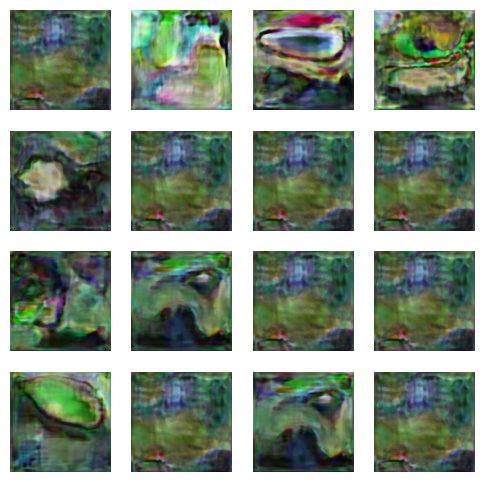

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

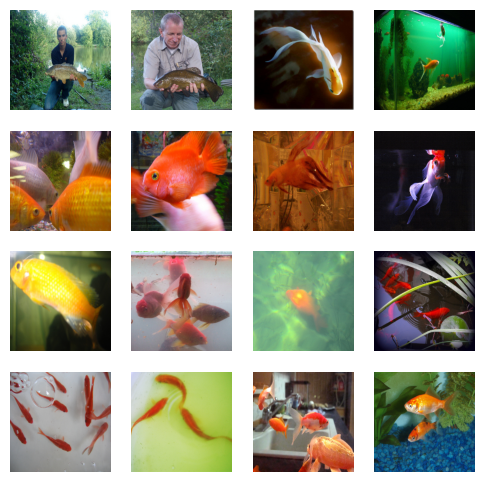

| It: 1 | Loss: -6.3893 | Time:   0.75s |


| It: 1001 | Loss: -61.1928 | Time: 783.89s |


| It: 2001 | Loss: -61.5200 | Time: 784.59s |


| It: 3001 | Loss: -61.6540 | Time: 785.68s |


| It: 4001 | Loss: -61.7500 | Time: 784.87s |


| It: 5001 | Loss: -61.7928 | Time: 784.47s |


| It: 6001 | Loss: -61.8291 | Time: 785.58s |


| It: 7001 | Loss: -61.8557 | Time: 784.69s |


| It: 8001 | Loss: -61.8719 | Time: 784.23s |


| It: 9001 | Loss: -61.8806 | Time: 785.83s |


| It: 1 | Loss: -19.7790 | Time:   0.84s |


| It: 1001 | Loss: -61.0211 | Time: 785.00s |


| It: 2001 | Loss: -61.4212 | Time: 785.36s |


| It: 3001 | Loss: -61.5694 | Time: 784.48s |


| It: 4001 | Loss: -61.6872 | Time: 785.54s |


| It: 5001 | Loss: -61.7541 | Time: 785.23s |


| It: 6001 | Loss: -61.7966 | Time: 783.99s |


| It: 7001 | Loss: -61.8290 | Time: 784.64s |


| It: 8001 | Loss: -61.8509 | Time: 785.57s |


| It: 9001 | Loss: -61.8612 | Time: 786.98s |


| It: 1 | Loss: -14.3591 | Time:   0.82s |


| It: 1001 | Loss: -61.1382 | Time: 785.04s |


| It: 2001 | Loss: -61.4629 | Time: 786.23s |


| It: 3001 | Loss: -61.6251 | Time: 784.60s |


| It: 4001 | Loss: -61.7060 | Time: 784.81s |


| It: 5001 | Loss: -61.7628 | Time: 785.30s |


| It: 6001 | Loss: -61.8089 | Time: 784.80s |


| It: 7001 | Loss: -61.8380 | Time: 785.38s |


| It: 8001 | Loss: -61.8571 | Time: 785.48s |


| It: 9001 | Loss: -61.8668 | Time: 785.45s |


| It: 1 | Loss: -32.5113 | Time:   0.77s |


| It: 1001 | Loss: -61.0035 | Time: 785.89s |


| It: 2001 | Loss: -61.4175 | Time: 785.77s |


| It: 3001 | Loss: -61.5954 | Time: 785.50s |


| It: 4001 | Loss: -61.6878 | Time: 785.46s |


| It: 5001 | Loss: -61.7601 | Time: 785.22s |


| It: 6001 | Loss: -61.7992 | Time: 786.47s |


| It: 7001 | Loss: -61.8319 | Time: 785.48s |


| It: 8001 | Loss: -61.8517 | Time: 785.74s |


| It: 9001 | Loss: -61.8614 | Time: 786.01s |


| It: 1 | Loss: -3.7800 | Time:   0.77s |


| It: 1001 | Loss: -60.9919 | Time: 785.55s |


| It: 2001 | Loss: -61.4496 | Time: 785.69s |


| It: 3001 | Loss: -61.6252 | Time: 785.35s |


| It: 4001 | Loss: -61.7177 | Time: 786.08s |


| It: 5001 | Loss: -61.7759 | Time: 785.40s |


| It: 6001 | Loss: -61.8183 | Time: 786.03s |


| It: 7001 | Loss: -61.8456 | Time: 785.00s |


| It: 8001 | Loss: -61.8618 | Time: 784.49s |


| It: 9001 | Loss: -61.8721 | Time: 786.01s |


BEST PSNR: 10.6170
MEDIAN PSNR: 10.1594
ALL PSNR: [10.0441, 10.1693, 9.3925, 10.6170, 10.6170]


<Figure size 400x300 with 0 Axes>

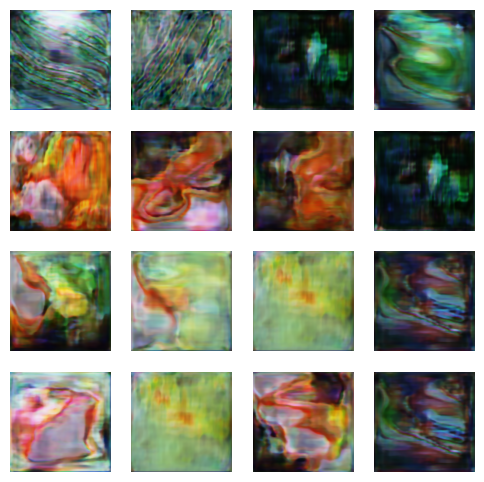

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

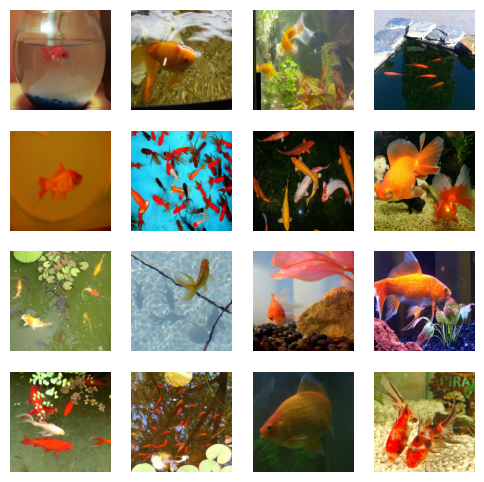

| It: 1 | Loss: -43.7357 | Time:   0.73s |


| It: 1001 | Loss: -59.5699 | Time: 784.76s |


| It: 2001 | Loss: -60.4356 | Time: 785.53s |


| It: 3001 | Loss: -60.8924 | Time: 784.79s |


| It: 4001 | Loss: -61.0866 | Time: 785.71s |


| It: 5001 | Loss: -61.3054 | Time: 785.48s |


| It: 6001 | Loss: -61.4244 | Time: 785.02s |


| It: 7001 | Loss: -61.5144 | Time: 785.73s |


| It: 8001 | Loss: -61.5663 | Time: 786.05s |


| It: 9001 | Loss: -61.5939 | Time: 784.78s |


| It: 1 | Loss: -39.0920 | Time:   0.82s |


| It: 1001 | Loss: -60.2506 | Time: 786.14s |


| It: 2001 | Loss: -60.8778 | Time: 786.19s |


| It: 3001 | Loss: -61.1490 | Time: 785.41s |


| It: 4001 | Loss: -61.3425 | Time: 785.30s |


| It: 5001 | Loss: -61.4626 | Time: 785.34s |


| It: 6001 | Loss: -61.5513 | Time: 784.61s |


| It: 7001 | Loss: -61.6173 | Time: 785.19s |


| It: 8001 | Loss: -61.6576 | Time: 785.08s |


| It: 9001 | Loss: -61.6793 | Time: 785.49s |


| It: 1 | Loss: -42.4187 | Time:   0.79s |


| It: 1001 | Loss: -59.9083 | Time: 786.14s |


| It: 2001 | Loss: -60.5963 | Time: 786.40s |


| It: 3001 | Loss: -60.9501 | Time: 786.49s |


| It: 4001 | Loss: -61.1876 | Time: 785.89s |


| It: 5001 | Loss: -61.3338 | Time: 786.06s |


| It: 6001 | Loss: -61.4708 | Time: 785.60s |


| It: 7001 | Loss: -61.5492 | Time: 784.60s |


| It: 8001 | Loss: -61.6048 | Time: 785.45s |


| It: 9001 | Loss: -61.6310 | Time: 784.69s |


| It: 1 | Loss: -43.4502 | Time:   0.82s |


| It: 1001 | Loss: -59.6057 | Time: 784.90s |


| It: 2001 | Loss: -60.5552 | Time: 785.72s |


| It: 3001 | Loss: -61.0203 | Time: 785.47s |


| It: 4001 | Loss: -61.2855 | Time: 785.51s |


| It: 5001 | Loss: -61.4205 | Time: 784.95s |


| It: 6001 | Loss: -61.5200 | Time: 785.83s |


| It: 7001 | Loss: -61.5880 | Time: 784.05s |


| It: 8001 | Loss: -61.6359 | Time: 785.54s |


| It: 9001 | Loss: -61.6589 | Time: 785.93s |


| It: 1 | Loss: -42.4640 | Time:   0.84s |


| It: 1001 | Loss: -59.0575 | Time: 784.96s |


| It: 2001 | Loss: -60.1414 | Time: 785.80s |


| It: 3001 | Loss: -60.6212 | Time: 785.82s |


| It: 4001 | Loss: -60.9234 | Time: 785.24s |


| It: 5001 | Loss: -61.1155 | Time: 784.93s |


| It: 6001 | Loss: -61.3086 | Time: 785.35s |


| It: 7001 | Loss: -61.4129 | Time: 785.56s |


| It: 8001 | Loss: -61.4856 | Time: 784.15s |


| It: 9001 | Loss: -61.5196 | Time: 783.56s |


BEST PSNR: 10.7882
MEDIAN PSNR: 9.5584
ALL PSNR: [8.3579, 9.9668, 10.7882, 8.3694, 8.3694]


<Figure size 400x300 with 0 Axes>

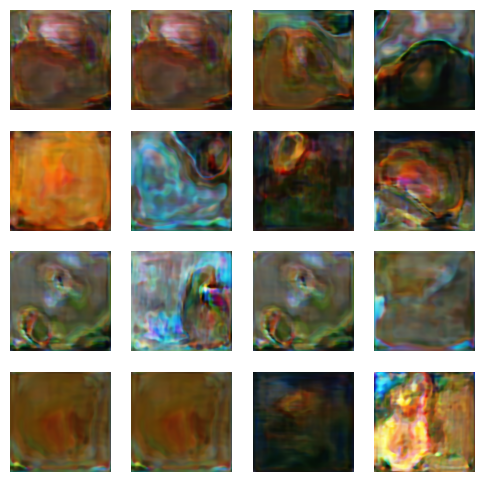

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

# data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, img_res=224, need_upscaling=False, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)